In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)

base_path = "datasets/cleaned/"

files = {
    "acidentes": f"{base_path}Acidentes_DadosAbertos_20250912.parquet",
    "localidades": f"{base_path}Localidade_DadosAbertos_20250912.parquet",
    "veiculos": f"{base_path}TipoVeiculo_DadosAbertos_20250912.parquet",
    "vitimas": f"{base_path}Vitimas_DadosAbertos_20250912.parquet"
}

print("📊 EDA SIMPLIFICADO - CARREGANDO DADOS")
print("="*50)
dfs = {name: pd.read_parquet(path) for name, path in files.items()}

for name, df in dfs.items():
    print(f"📂 {name.upper()} → {df.shape[0]:,} linhas | {df.shape[1]} colunas")

📊 EDA SIMPLIFICADO - CARREGANDO DADOS
📂 ACIDENTES → 1,673,564 linhas | 37 colunas
📂 LOCALIDADES → 498,133 linhas | 12 colunas
📂 VEICULOS → 6,860,268 linhas | 4 colunas
📂 VITIMAS → 8,028,049 linhas | 18 colunas


🏍️ PERGUNTA 1: Motocicletas têm mais acidentes com óbitos que automóveis?

📊 Registros analisados: 6,951,455
Distribuição por veículo:
tipo_veiculo
AUTOMOVEL      5168941
MOTOCICLETA    1782514
Name: count, dtype: int64

📈 RESULTADOS:
  Motocicletas: 0.0179 (1.79%) acidentes com óbito
  Automóveis: 0.0059 (0.59%) acidentes com óbito
  Diferença: +201.3%


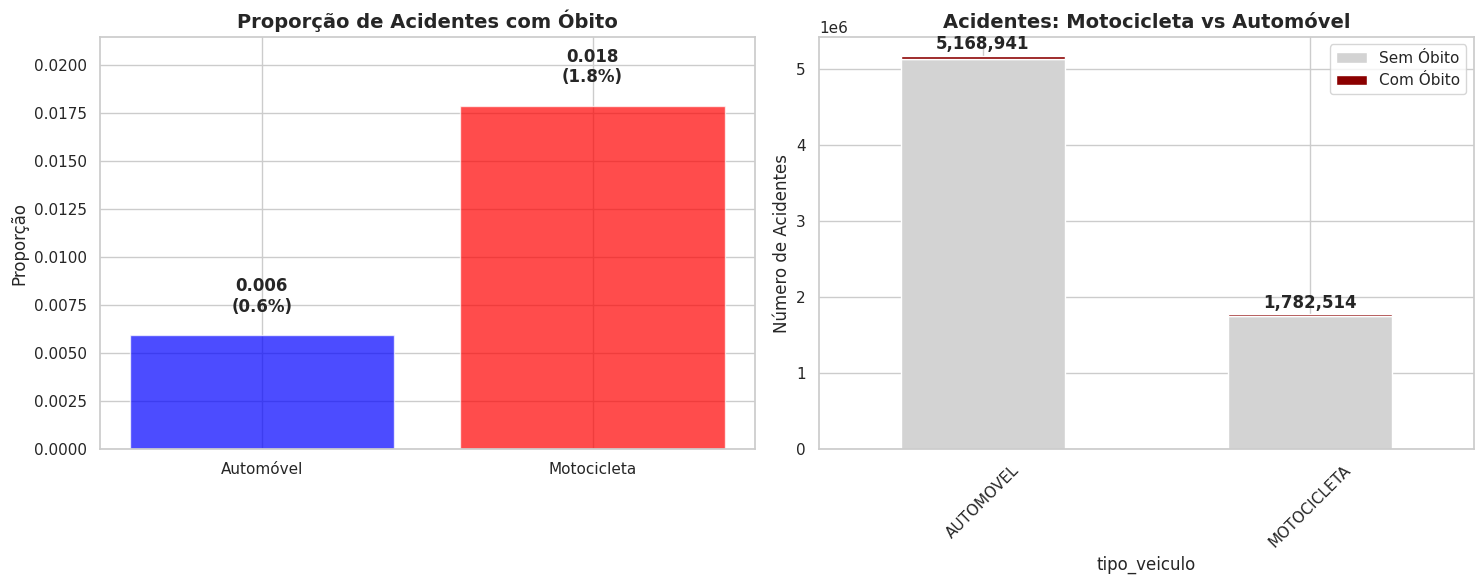

In [2]:
print("🏍️ PERGUNTA 1: Motocicletas têm mais acidentes com óbitos que automóveis?")
print("="*70)

df_veic = dfs["veiculos"]
df_vit = dfs["vitimas"]

df_moto_auto = df_veic.merge(df_vit, on="num_acidente", how="inner")
df_moto_auto = df_moto_auto[df_moto_auto['tipo_veiculo'].isin(['MOTOCICLETA', 'AUTOMOVEL'])].copy()

if df_moto_auto['tipo_veiculo'].dtype.name == 'category':
    df_moto_auto['tipo_veiculo'] = df_moto_auto['tipo_veiculo'].cat.remove_unused_categories()

df_moto_auto['tem_obito'] = df_moto_auto['qtde_obitos'] > 0

print(f"\n📊 Registros analisados: {len(df_moto_auto):,}")
print("Distribuição por veículo:")

counts_veiculos = df_moto_auto['tipo_veiculo'].value_counts()
counts_veiculos = counts_veiculos[counts_veiculos > 0] 
print(counts_veiculos)

prop_por_veiculo = df_moto_auto.groupby('tipo_veiculo', observed=True)['tem_obito'].agg(['count', 'sum', 'mean'])
prop_moto = prop_por_veiculo.loc['MOTOCICLETA', 'mean']
prop_auto = prop_por_veiculo.loc['AUTOMOVEL', 'mean']

print(f"\n📈 RESULTADOS:")
print(f"  Motocicletas: {prop_moto:.4f} ({prop_moto*100:.2f}%) acidentes com óbito")
print(f"  Automóveis: {prop_auto:.4f} ({prop_auto*100:.2f}%) acidentes com óbito")
print(f"  Diferença: {((prop_moto-prop_auto)/prop_auto*100):+.1f}%")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Proporção de óbitos
props = [prop_auto, prop_moto]
veiculos = ['Automóvel', 'Motocicleta']
colors = ['blue', 'red']

bars1 = ax1.bar(veiculos, props, color=colors, alpha=0.7)
ax1.set_title("Proporção de Acidentes com Óbito", fontsize=14, fontweight='bold')
ax1.set_ylabel("Proporção")
ax1.set_ylim(0, max(props) * 1.2)

for bar, prop in zip(bars1, props):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'{prop:.3f}\n({prop*100:.1f}%)', ha='center', va='bottom', fontweight='bold')

# Plot 2: Contagens absolutas APENAS para moto e carro (com observed=True)
counts = df_moto_auto.groupby(['tipo_veiculo', 'tem_obito'], observed=True).size().unstack()
counts.plot(kind='bar', ax=ax2, color=['lightgray', 'darkred'], stacked=True)
ax2.set_title("Acidentes: Motocicleta vs Automóvel", fontsize=14, fontweight='bold')
ax2.set_ylabel("Número de Acidentes")
ax2.legend(['Sem Óbito', 'Com Óbito'])
ax2.tick_params(axis='x', rotation=45)

for i, (veiculo, row) in enumerate(counts.iterrows()):
    total = row.sum()
    ax2.text(i, total + total*0.01, f'{total:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

📅 PERGUNTA 2: Finais de semana têm mais acidentes graves?

📊 ESTATÍSTICAS POR PERÍODO:
            num_acidente  qtde_acid_com_obitos  qtde_obitos  \
fim_semana                                                    
False            1204234                 17184        18934   
True              469330                 12326        13932   

            prop_acid_com_obitos  
fim_semana                        
False                   0.014270  
True                    0.026263  

📈 RESULTADOS:
  Fins de semana: 0.0263 (2.63%) acidentes com óbito
  Dias úteis: 0.0143 (1.43%) acidentes com óbito
  Diferença: +84.0%


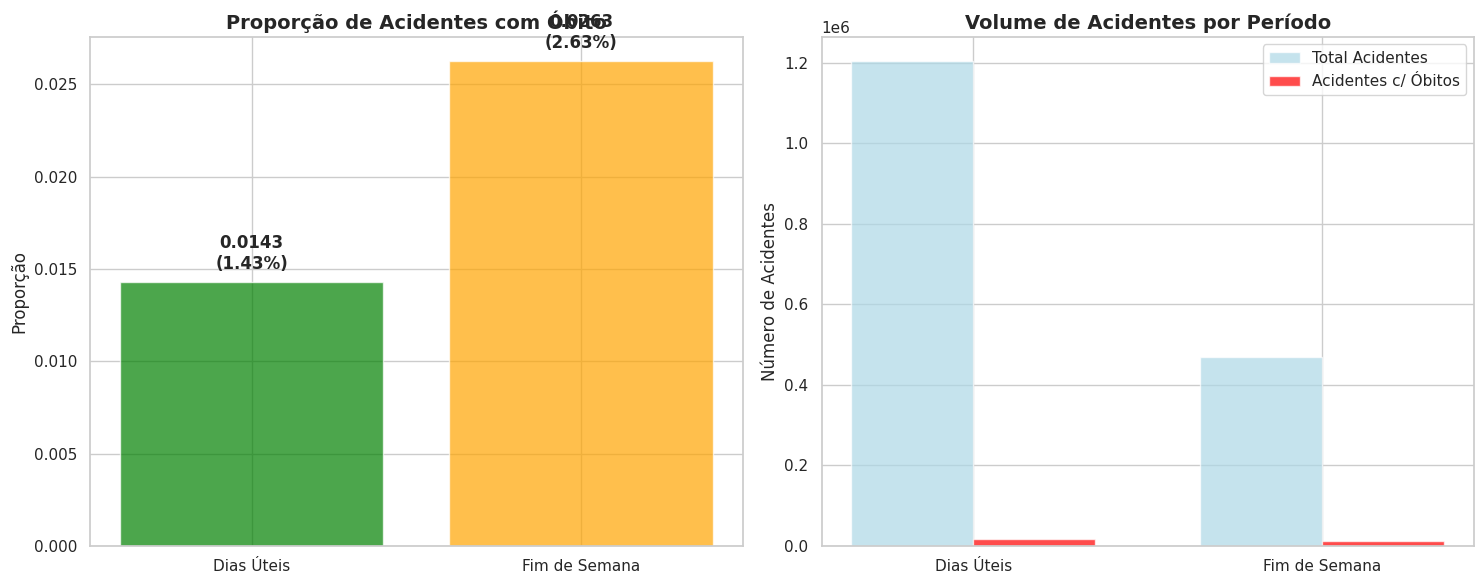

In [3]:
print("📅 PERGUNTA 2: Finais de semana têm mais acidentes graves?")
print("="*60)

df_acc = dfs["acidentes"]

# Criar variável fim de semana se não existir
if 'fim_semana' not in df_acc.columns:
    df_acc['fim_semana'] = df_acc['dia_semana'].isin(['SABADO', 'DOMINGO'])

stats_temporal = df_acc.groupby('fim_semana').agg({
    'num_acidente': 'count',
    'qtde_acid_com_obitos': 'sum',
    'qtde_obitos': 'sum'
}).round(4)

stats_temporal['prop_acid_com_obitos'] = stats_temporal['qtde_acid_com_obitos'] / stats_temporal['num_acidente']

prop_fds = stats_temporal.loc[True, 'prop_acid_com_obitos']
prop_util = stats_temporal.loc[False, 'prop_acid_com_obitos']

print(f"\n📊 ESTATÍSTICAS POR PERÍODO:")
print(stats_temporal)

print(f"\n📈 RESULTADOS:")
print(f"  Fins de semana: {prop_fds:.4f} ({prop_fds*100:.2f}%) acidentes com óbito")
print(f"  Dias úteis: {prop_util:.4f} ({prop_util*100:.2f}%) acidentes com óbito")
print(f"  Diferença: {((prop_fds-prop_util)/prop_util*100):+.1f}%")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Proporção de acidentes com óbito
periodos = ['Dias Úteis', 'Fim de Semana']
props = [prop_util, prop_fds]
colors = ['green', 'orange']

bars1 = ax1.bar(periodos, props, color=colors, alpha=0.7)
ax1.set_title("Proporção de Acidentes com Óbito", fontsize=14, fontweight='bold')
ax1.set_ylabel("Proporção")

for bar, prop in zip(bars1, props):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0005, 
             f'{prop:.4f}\n({prop*100:.2f}%)', ha='center', va='bottom', fontweight='bold')

# Plot 2: Volume total vs acidentes com óbito
x = np.arange(len(periodos))
width = 0.35

totais = [stats_temporal.loc[False, 'num_acidente'], stats_temporal.loc[True, 'num_acidente']]
obitos = [stats_temporal.loc[False, 'qtde_acid_com_obitos'], stats_temporal.loc[True, 'qtde_acid_com_obitos']]

ax2.bar(x - width/2, totais, width, label='Total Acidentes', alpha=0.7, color='lightblue')
ax2.bar(x + width/2, obitos, width, label='Acidentes c/ Óbitos', alpha=0.7, color='red')
ax2.set_title("Volume de Acidentes por Período", fontsize=14, fontweight='bold')
ax2.set_ylabel("Número de Acidentes")
ax2.set_xticks(x)
ax2.set_xticklabels(periodos)
ax2.legend()

plt.tight_layout()
plt.show()

👥 PERGUNTA 3: Jovens (18-34) se acidentam mais?
✅ Usando coluna de idade: faixa_idade_simples

📊 ESTATÍSTICAS POR FAIXA ETÁRIA (Vítimas):
faixa_idade_simples  num_vitimas  prop_vitimas
     ADULTO (35-59)      3882981      0.483677
      JOVEM (18-34)      3246117      0.404347
             OUTROS       526808      0.065621
        IDOSO (60+)       372143      0.046355

📈 RESULTADOS COMPARATIVOS:
  Jovens (18-34):
    Total de vítimas: 3,246,117 (40.4%)
    Acidentes únicos envolvendo jovens: 2,722,546

  Outras faixas etárias:
    Total de vítimas: 4,781,932 (59.6%)
    Acidentes únicos envolvendo outros grupos: 3,719,077

📊 ÓBITOS EM ACIDENTES ENVOLVENDO:
  Jovens:
    Total de óbitos: 10,170.0
    Taxa de óbitos por acidente: 0.0037

  Outros:
    Total de óbitos: 14,654.0
    Taxa de óbitos por acidente: 0.0039

  Diferença na taxa: -5.2%


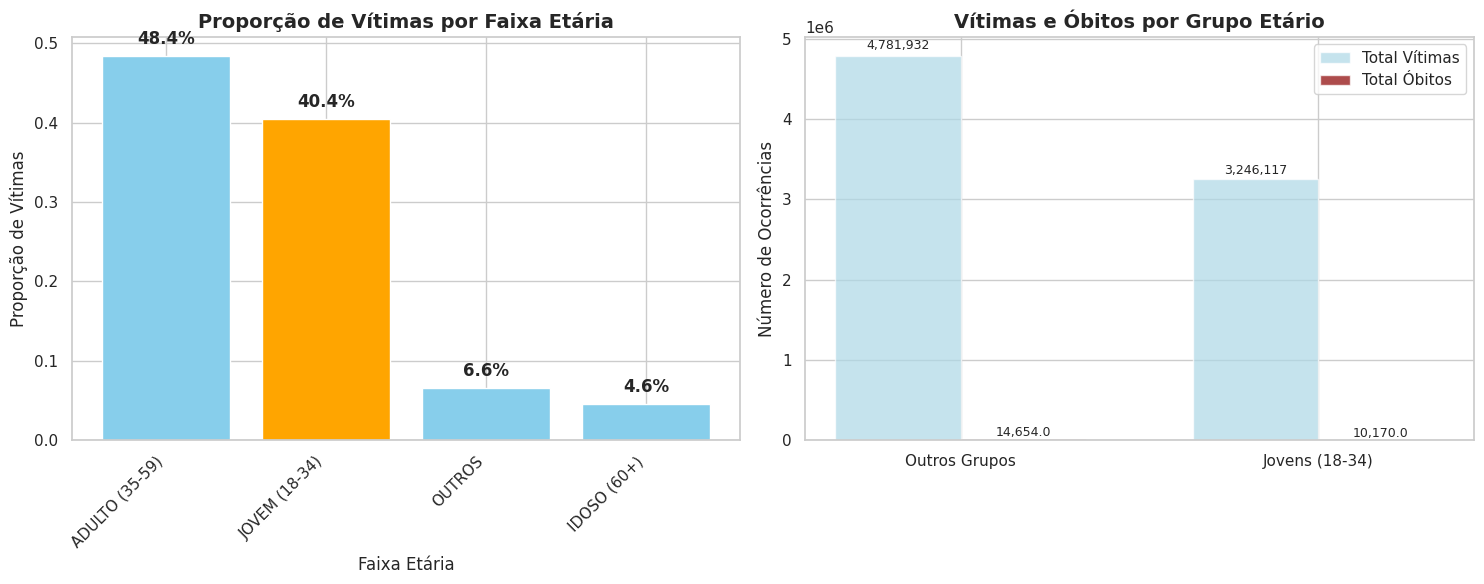

In [4]:
print("👥 PERGUNTA 3: Jovens (18-34) se acidentam mais?")
print("="*70)

df_vit = dfs["vitimas"]
df_acc = dfs["acidentes"]

idade_col = 'faixa_idade_simples' if 'faixa_idade_simples' in df_vit.columns else 'faixa_idade'
print(f"✅ Usando coluna de idade: {idade_col}")

if idade_col in df_vit.columns:
    stats_idade = df_vit.groupby(idade_col).agg({
        'num_acidente': 'count'  # contar registros de vítimas
    }).reset_index()
    stats_idade.columns = [idade_col, 'num_vitimas']
    
    stats_idade['prop_vitimas'] = stats_idade['num_vitimas'] / stats_idade['num_vitimas'].sum()
    stats_idade = stats_idade.sort_values('num_vitimas', ascending=False)
    
    print("\n📊 ESTATÍSTICAS POR FAIXA ETÁRIA (Vítimas):")
    print(stats_idade.to_string(index=False))
    
    jovens = df_vit[df_vit[idade_col] == 'JOVEM (18-34)']
    outros = df_vit[df_vit[idade_col] != 'JOVEM (18-34)']
    
    n_jovens = len(jovens)
    n_outros = len(outros)
    
    acidentes_jovens = jovens['num_acidente'].nunique()
    acidentes_outros = outros['num_acidente'].nunique()
    
    prop_jovens = n_jovens / (n_jovens + n_outros) if (n_jovens + n_outros) > 0 else 0
    prop_outros = n_outros / (n_jovens + n_outros) if (n_jovens + n_outros) > 0 else 0
    
    print(f"\n📈 RESULTADOS COMPARATIVOS:")
    print(f"  Jovens (18-34):")
    print(f"    Total de vítimas: {n_jovens:,} ({prop_jovens*100:.1f}%)")
    print(f"    Acidentes únicos envolvendo jovens: {acidentes_jovens:,}")
    
    print(f"\n  Outras faixas etárias:")
    print(f"    Total de vítimas: {n_outros:,} ({prop_outros*100:.1f}%)")
    print(f"    Acidentes únicos envolvendo outros grupos: {acidentes_outros:,}")

    df_acc_obitos = df_acc[["num_acidente", "qtde_obitos", "qtde_acid_com_obitos"]].copy()
    
    df_idade_obitos = df_vit[[idade_col, 'num_acidente']].merge(df_acc_obitos, on="num_acidente", how="left")
    

    obitos_por_acidente_jovens = df_idade_obitos[
        df_idade_obitos[idade_col] == 'JOVEM (18-34)'
    ].groupby('num_acidente')['qtde_obitos'].first().sum()
    
    obitos_por_acidente_outros = df_idade_obitos[
        df_idade_obitos[idade_col] != 'JOVEM (18-34)'
    ].groupby('num_acidente')['qtde_obitos'].first().sum()
    
    taxa_obito_jovens = obitos_por_acidente_jovens / acidentes_jovens if acidentes_jovens > 0 else 0
    taxa_obito_outros = obitos_por_acidente_outros / acidentes_outros if acidentes_outros > 0 else 0
    
    print(f"\n📊 ÓBITOS EM ACIDENTES ENVOLVENDO:")
    print(f"  Jovens:")
    print(f"    Total de óbitos: {obitos_por_acidente_jovens:,}")
    print(f"    Taxa de óbitos por acidente: {taxa_obito_jovens:.4f}")
    
    print(f"\n  Outros:")
    print(f"    Total de óbitos: {obitos_por_acidente_outros:,}")
    print(f"    Taxa de óbitos por acidente: {taxa_obito_outros:.4f}")
    
    if taxa_obito_outros > 0:
        print(f"\n  Diferença na taxa: {((taxa_obito_jovens-taxa_obito_outros)/taxa_obito_outros*100):+.1f}%")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Proporção de vítimas por faixa etária (top 5)
    top_faixas = stats_idade.head(5)
    bars1 = ax1.bar(range(len(top_faixas)), top_faixas['prop_vitimas'], 
                    color=['orange' if x == 'JOVEM (18-34)' else 'skyblue' for x in top_faixas[idade_col]])
    ax1.set_title("Proporção de Vítimas por Faixa Etária", fontsize=14, fontweight='bold')
    ax1.set_ylabel("Proporção de Vítimas")
    ax1.set_xlabel("Faixa Etária")
    ax1.set_xticks(range(len(top_faixas)))
    ax1.set_xticklabels(top_faixas[idade_col], rotation=45, ha='right')
    
    for i, (idx, row) in enumerate(top_faixas.iterrows()):
        ax1.text(i, row['prop_vitimas'] + 0.01, 
                 f'{row["prop_vitimas"]*100:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # Plot 2: Comparação Jovens vs Outros - Vítimas e Óbitos
    x = np.arange(2)
    width = 0.35
    
    grupos = ['Outros Grupos', 'Jovens (18-34)']
    totais_vitimas = [n_outros, n_jovens]
    totais_obitos = [obitos_por_acidente_outros, obitos_por_acidente_jovens]
    
    ax2.bar(x - width/2, totais_vitimas, width, label='Total Vítimas', alpha=0.7, color='lightblue')
    ax2.bar(x + width/2, totais_obitos, width, label='Total Óbitos', alpha=0.7, color='darkred')
    ax2.set_title("Vítimas e Óbitos por Grupo Etário", fontsize=14, fontweight='bold')
    ax2.set_ylabel("Número de Ocorrências")
    ax2.set_xticks(x)
    ax2.set_xticklabels(grupos)
    ax2.legend()
    
    for i in range(len(x)):
        ax2.text(i - width/2, totais_vitimas[i] + totais_vitimas[i]*0.01, 
                f'{totais_vitimas[i]:,}', ha='center', va='bottom', fontsize=9)
        ax2.text(i + width/2, totais_obitos[i] + totais_obitos[i]*0.01, 
                f'{totais_obitos[i]:,}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠️  Coluna de idade não encontrada")


🛣️ PERGUNTA 4: Rodovias federais têm mais óbitos?
✅ Variável de rodovia encontrada!


📊 Dados com tipo de rodovia válido: 858,992 de 1,673,564 registros

📊 ESTATÍSTICAS POR TIPO DE RODOVIA:
tp_rodovia_simples  num_acidente  qtde_obitos  qtde_acid_com_obitos  prop_acid_com_obitos  taxa_obitos
          ESTADUAL        155379        10805                  9453              0.060838     0.069540
         MUNICIPAL        661804         7118                  6749              0.010198     0.010755
           FEDERAL         41809         1656                  1477              0.035327     0.039609

📈 RESULTADOS COMPARATIVOS:
  Rodovias Federais:
    Total de acidentes: 41,809 (4.9%)
    Total de óbitos: 1,656
    Proporção de acidentes com óbito: 0.0353 (3.53%)
    Taxa de óbitos por acidente: 0.0396

  Outras Rodovias:
    Total de acidentes: 817,183 (95.1%)
    Total de óbitos: 17,923
    Proporção de acidentes com óbito: 0.0198 (1.98%)
    Taxa de óbitos por acidente: 0.0219

  Diferença na proporção: +78.2%
  Diferença na taxa: +80.6%


/tmp/ipykernel_381623/3014294823.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc_clean['tp_rodovia_simples'] = df_acc_clean['tp_rodovia'].apply(categorize_rodovia)


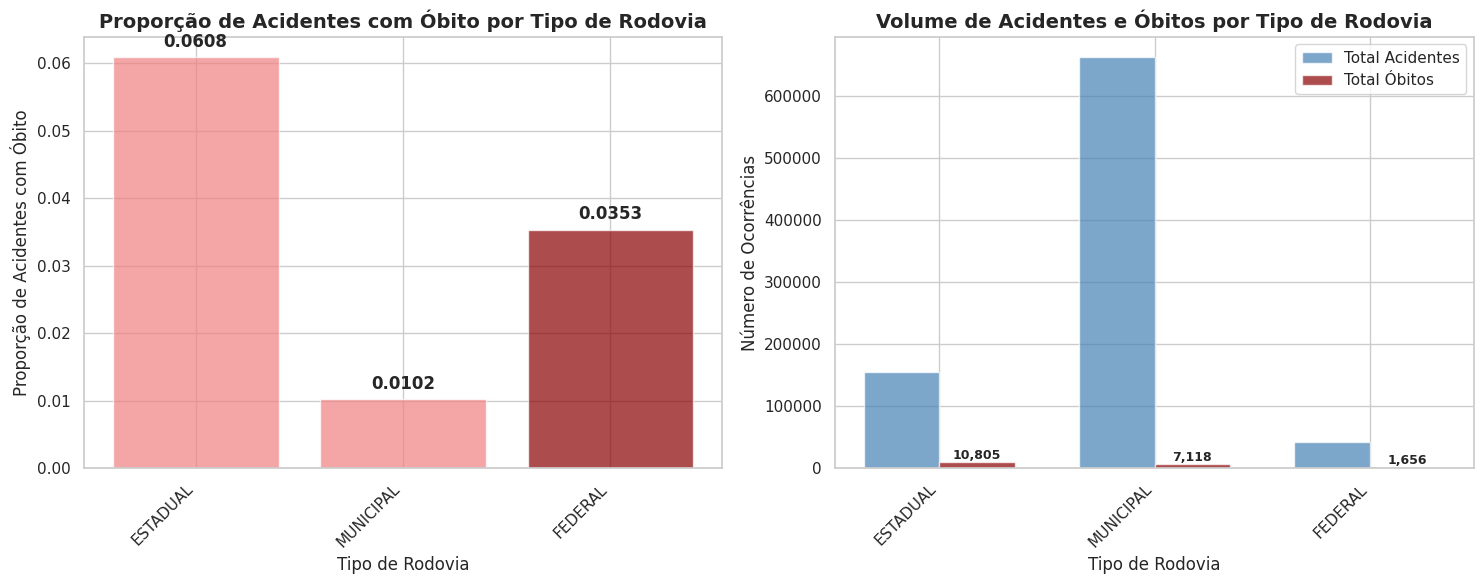

In [5]:
print("🛣️ PERGUNTA 4: Rodovias federais têm mais óbitos?")
print("="*70)

df_acc = dfs["acidentes"]

if 'tp_rodovia' in df_acc.columns:
    print("✅ Variável de rodovia encontrada!")
    
    missing_patterns = ['NAO INFORMADO', 'NÃO INFORMADO', 'DESCONHECIDO', 
                       'SEM INFORMACAO', 'SEM INFORMAÇÃO', 'IGNORADO']
    
    mask_rodovia_valida = ~df_acc['tp_rodovia'].astype(str).str.upper().isin(missing_patterns)
    df_acc_clean = df_acc[mask_rodovia_valida]
    
    print(f"📊 Dados com tipo de rodovia válido: {len(df_acc_clean):,} de {len(df_acc):,} registros")
    
    def categorize_rodovia(tp_rodovia):
        if pd.isna(tp_rodovia):
            return 'OUTROS'
        tp_str = str(tp_rodovia).upper()
        if 'FEDERAL' in tp_str:
            return 'FEDERAL'
        elif 'ESTADUAL' in tp_str:
            return 'ESTADUAL'
        elif 'MUNICIPAL' in tp_str:
            return 'MUNICIPAL'
        else:
            return 'OUTROS'
    
    df_acc_clean['tp_rodovia_simples'] = df_acc_clean['tp_rodovia'].apply(categorize_rodovia)
    
    stats_rodovia = df_acc_clean.groupby('tp_rodovia_simples').agg({
        'num_acidente': 'count',
        'qtde_obitos': 'sum',
        'qtde_acid_com_obitos': 'sum'
    }).reset_index()
    
    stats_rodovia['prop_acid_com_obitos'] = stats_rodovia['qtde_acid_com_obitos'] / stats_rodovia['num_acidente']

    stats_rodovia['taxa_obitos'] = stats_rodovia['qtde_obitos'] / stats_rodovia['num_acidente']
    stats_rodovia = stats_rodovia.sort_values('qtde_obitos', ascending=False)
    
    print("\n📊 ESTATÍSTICAS POR TIPO DE RODOVIA:")
    print(stats_rodovia.to_string(index=False))
    
    # Comparação específica: Federais vs Outras
    federais = df_acc_clean[df_acc_clean['tp_rodovia_simples'] == 'FEDERAL']
    outras = df_acc_clean[df_acc_clean['tp_rodovia_simples'] != 'FEDERAL']
    
    n_fed = len(federais)
    n_out = len(outras)
    obitos_fed = federais['qtde_obitos'].sum()
    obitos_out = outras['qtde_obitos'].sum()
    
    prop_fed = federais['qtde_acid_com_obitos'].sum() / n_fed if n_fed > 0 else 0
    prop_out = outras['qtde_acid_com_obitos'].sum() / n_out if n_out > 0 else 0
    
    taxa_fed = obitos_fed / n_fed if n_fed > 0 else 0
    taxa_out = obitos_out / n_out if n_out > 0 else 0
    
    print(f"\n📈 RESULTADOS COMPARATIVOS:")
    print(f"  Rodovias Federais:")
    print(f"    Total de acidentes: {n_fed:,} ({n_fed/(n_fed+n_out)*100:.1f}%)")
    print(f"    Total de óbitos: {obitos_fed:,}")
    print(f"    Proporção de acidentes com óbito: {prop_fed:.4f} ({prop_fed*100:.2f}%)")
    print(f"    Taxa de óbitos por acidente: {taxa_fed:.4f}")
    
    print(f"\n  Outras Rodovias:")
    print(f"    Total de acidentes: {n_out:,} ({n_out/(n_fed+n_out)*100:.1f}%)")
    print(f"    Total de óbitos: {obitos_out:,}")
    print(f"    Proporção de acidentes com óbito: {prop_out:.4f} ({prop_out*100:.2f}%)")
    print(f"    Taxa de óbitos por acidente: {taxa_out:.4f}")
    
    if prop_out > 0:
        print(f"\n  Diferença na proporção: {((prop_fed-prop_out)/prop_out*100):+.1f}%")
    if taxa_out > 0:
        print(f"  Diferença na taxa: {((taxa_fed-taxa_out)/taxa_out*100):+.1f}%")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Proporção de acidentes com óbito por tipo de rodovia
    tipos = stats_rodovia['tp_rodovia_simples'].tolist()
    props = stats_rodovia['prop_acid_com_obitos'].tolist()
    colors = ['darkred' if x == 'FEDERAL' else 'lightcoral' for x in tipos]
    
    bars1 = ax1.bar(range(len(tipos)), props, color=colors, alpha=0.7)
    ax1.set_title("Proporção de Acidentes com Óbito por Tipo de Rodovia", 
                  fontsize=14, fontweight='bold')
    ax1.set_ylabel("Proporção de Acidentes com Óbito")
    ax1.set_xlabel("Tipo de Rodovia")
    ax1.set_xticks(range(len(tipos)))
    ax1.set_xticklabels(tipos, rotation=45, ha='right')
    
    for i, prop in enumerate(props):
        ax1.text(i, prop + 0.001, f'{prop:.4f}', 
                ha='center', va='bottom', fontweight='bold')
    
    # Plot 2: Volume total de óbitos por tipo de rodovia
    x = np.arange(len(tipos))
    width = 0.35
    
    totais = stats_rodovia['num_acidente'].tolist()
    obitos_list = stats_rodovia['qtde_obitos'].tolist()
    
    ax2.bar(x - width/2, totais, width, label='Total Acidentes', alpha=0.7, color='steelblue')
    ax2.bar(x + width/2, obitos_list, width, label='Total Óbitos', alpha=0.7, color='darkred')
    ax2.set_title("Volume de Acidentes e Óbitos por Tipo de Rodovia", 
                  fontsize=14, fontweight='bold')
    ax2.set_ylabel("Número de Ocorrências")
    ax2.set_xlabel("Tipo de Rodovia")
    ax2.set_xticks(x)
    ax2.set_xticklabels(tipos, rotation=45, ha='right')
    ax2.legend()
    
    for i in range(len(x)):
        ax2.text(i + width/2, obitos_list[i] + obitos_list[i]*0.01, 
                f'{obitos_list[i]:,}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠️  Variável de tipo de rodovia não encontrada")
    print("Variáveis disponíveis:")
    rodovia_vars = [col for col in df_acc.columns if 'rodovia' in col.lower()]
    print(f"  Rodovia: {rodovia_vars}")
